# 개요

검색에 대해 A: 34, B: 33, C: 33 으로 테스트 실시했던 결과 판정

스펙

* 안드로이드
* 4.42.0 + 4.41.2
* 2019년 6월25일 실험


## Baeysian Method for AB testing

참고문헌

* https://cdn2.hubspot.net/hubfs/310840/VWO_SmartStats_technical_whitepaper.pdf
* http://www.evanmiller.org/bayesian-ab-testing.html
* https://portal.pixelfederation.com/ro/blog/article/22
* https://docs.pymc.io/

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
!pip install arviz

%matplotlib inline
import numpy as np
import pymc3 as pm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-darkgrid')

print('Running on PyMC3 v{}'.format(pm.__version__))
import IPython.display as display

Running on PyMC3 v3.7


## GCP specific tasks

In [0]:
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
from google.cloud import bigquery

In [0]:
# [PASS!!!]그룹별 전체 유저수 - 6월 25일 자 데이터에는 없다.
sql = """
select testCode, count(distinct fullVisitorID) users 
from `wmpga360.wmp_ga_anal.unique_fullvisitorID_20190606`
group by testCode
"""

client = bigquery.Client(project="eighth-edge-810")
df_users = client.query(sql).to_dataframe()

In [0]:
df_users.set_index('testCode', inplace=True)

In [0]:
df_users

# 주문 금액의 랭킹에 따라 처리

### 모든 주문 처리 [0%~100%]

In [0]:
# 전체 거래, CM
sql = """
SELECT testCode, count(distinct pcstamp) pu, count(*) order_cnt, sum(order_price) order_sum, sum(cm2) cm_sum 
FROM 
`wmpga360.wmp_ga_anal.apptracking_ABtest_cm_20190625` 
where cm2 is not null 
group by testCode
"""

client = bigquery.Client(project="eighth-edge-810")
df_whole_cm = client.query(sql).to_dataframe()

In [0]:
df_whole_cm.set_index('testCode', inplace=True)

In [0]:
df_whole_cm

,pu,order_cnt,order_sum,cm_sum
testCode,,,,
B,44348,79260,2633633120,65891748
C,45162,79967,2590318288,65218390
A,45387,80810,2661881269,66416606


In [0]:
# 거래 한 user들 비율 살핌 - 검색에서 아무래도 B/C 타입으로 거래 유입된 인원들이 좀 있겠지?
df_whole_cm.pu/df_whole_cm.pu.sum()

testCode
B    0.328755
C    0.334789
A    0.336457
Name: pu, dtype: float64

In [0]:
# 주문들의 비율 살핌 - 여기서도 상식적으로는 B/C 타입의 거래 유입이 더 있겠지(그래도 검색에서 샀다고 비검색에서 안사는게 아니야. 혹은, 아무것도 안살사람도 검색에서 사게되거나)
df_whole_cm.order_cnt/df_whole_cm.order_cnt.sum()

testCode
B    0.330199
C    0.333144
A    0.336656
Name: order_cnt, dtype: float64

In [0]:
# 거래액의 비율? - 거래 비율에서의 차이가.. 전체 거래액에서의 차이로 이어질까?
df_whole_cm.order_sum/df_whole_cm.order_sum.sum()

testCode
B    0.333970
C    0.328477
A    0.337552
Name: order_sum, dtype: float64

In [0]:
# 검색 거래, CM
sql = """
SELECT testCode, count(distinct pcstamp) pu, count(*) order_cnt, sum(order_price) order_sum, sum(cm2) cm_sum 
FROM `wmpga360.wmp_ga_anal.apptracking_ABtest_cm_20190625` 
where cm2 is not null and searchYn='Y'
group by testCode
"""

client = bigquery.Client(project="eighth-edge-810")
df_search_cm = client.query(sql).to_dataframe()

In [0]:
df_search_cm.set_index('testCode', inplace=True)

In [0]:
df_search_cm # d

,pu,order_cnt,order_sum,cm_sum
testCode,,,,
A,22645,32645,1393151528,21248673
C,22865,33191,1347416080,20654247
B,22217,32423,1382139533,20632020


In [0]:
# 검색에서
# 거래 한 user들 비율 살핌 - 검색에서 아무래도 B/C 타입으로 거래 유입된 인원들이 좀 있겠지?
df_search_cm.pu/df_search_cm.pu.sum()

testCode
A    0.334357
C    0.337605
B    0.328038
Name: pu, dtype: float64

In [0]:
# 검색에서
# 주문들의 비율 살핌 
df_search_cm.order_cnt/df_search_cm.order_cnt.sum()

testCode
A    0.332234
C    0.337791
B    0.329975
Name: order_cnt, dtype: float64

In [0]:
# 거래액의 비율? 
df_search_cm.order_sum/df_search_cm.order_sum.sum()

testCode
A    0.337922
C    0.326828
B    0.335250
Name: order_sum, dtype: float64



---



## 분석 세팅

In [0]:
df_whole_cm

,pu,order_cnt,order_sum,cm_sum
testCode,,,,
B,44348,79260,2633633120,65891748
C,45162,79967,2590318288,65218390
A,45387,80810,2661881269,66416606


In [0]:
A='A'
B='B'
C='C'
#VIEW='order_sum'
VIEW='cm_sum'

In [0]:
# 대조군/실험군 유저수
n1 = 355938
n2 = 345429
n3 = 345855

#n1 = df_users.loc[A]['users']
#n2 = df_users.loc[B]['users']
#n3 = df_users.loc[C]['users']

In [0]:
df_data = df_whole_cm
#df_data = df_search_cm # 검색만 가지고 할때
#DATA='whole_[0-95]'

In [0]:
df_data.loc[A]['pu']

45387

In [0]:
df_data.loc[A]['order_sum']

2661881269

In [0]:
c1 = df_data.loc[A]['pu'] # user수
c2 = df_data.loc[B]['pu']
c3 = df_data.loc[C]['pu']

r1 = df_data.loc[A]['order_sum']/c1 # 구매 user당 주문금액(revenue)
r2 = df_data.loc[B]['order_sum']/c2
r3 = df_data.loc[C]['order_sum']/c3



s1 = df_data.loc[A][VIEW]/c1 # 구매 user당 평균 cm
s2 = df_data.loc[B][VIEW]/c2
s3 = df_data.loc[C][VIEW]/c3

In [0]:
pd.DataFrame({'total_user' : [n1,n2,n3], 
             'paid_user' : [c1, c2, c3],
             'arppu' : [r1, r2, r3],
             'arpu': [r1*c1/n1, r2*c2/n2, r3*c3/n3],
             'arppu_cm' : [s1, s2, s3],
             'arpu_cm' : [s1*c1/n1, s2*c2/n2, s3*c3/n3]})

,total_user,paid_user,arppu,arpu,arppu_cm,arpu_cm
0,355938,45387,58648.539648,7478.497011,1463.339855,186.595997
1,345429,44348,59385.611978,7624.238613,1485.788491,190.753376
2,345855,45162,57356.146495,7489.607749,1444.098800,188.571482




---



## Bayesian AB Test for Conversion and ARPU (Average Revenue per User) - revenue 관점

conversion
= 구매유저수 / 유저수

ARPU
= 총구매금액 / 유저수

MCMC 모델
https://cdn2.hubspot.net/hubfs/310840/VWO_SmartStats_technical_whitepaper.pdf 를 따름


In [0]:
n1+n2+n3

1047222

In [0]:
# prior 설정
cr_hyperparameter={'alpha':1.0, 'beta':1.0}
lambda_hyperparams={'alpha':1.0, 'beta':1.0}
theta_hyperparams={'alpha':1.0, 'beta':0.5}

In [0]:
# conversion을 '고객' 관점에서 살핀다.

with pm.Model() as model: # context management
  ## Conversion 관련
  cr_a = pm.Beta('cr_a', alpha=lambda_hyperparams['alpha'], beta=lambda_hyperparams['beta'])
  cr_b = pm.Beta('cr_b', alpha=lambda_hyperparams['alpha'], beta=lambda_hyperparams['beta'])
  cr_c = pm.Beta('cr_c', alpha=lambda_hyperparams['alpha'], beta=lambda_hyperparams['beta'])
  
  # define likelihood
  like_cr_a = pm.Binomial('like_cr_a', n=n1, p=cr_a, observed=c1) # 구매고객/전체고객 으로 conversion
  like_cr_b = pm.Binomial('like_cr_b', n=n2, p=cr_b, observed=c2)
  like_cr_c = pm.Binomial('like_cr_c', n=n3, p=cr_c, observed=c3)

  # define metrics
  pm.Deterministic('difference_conversion_ba', cr_b - cr_a)
  pm.Deterministic('difference_conversion_ca', cr_c - cr_a)
  #pm.Deterministic('loss_cr_a', pm.math.switch(cr_b - cr_a > 0, cr_b - cr_a, 0))
  pm.Deterministic('loss_cr_a', pm.math.maximum(pm.math.maximum(cr_b - cr_a, cr_c - cr_a), 0.0))
  pm.Deterministic('loss_cr_b', pm.math.maximum(pm.math.maximum(cr_a - cr_b, cr_c - cr_b), 0.0))
  pm.Deterministic('loss_cr_c', pm.math.maximum(pm.math.maximum(cr_a - cr_c, cr_b - cr_c), 0.0))

  
  ## 거래액(revenue) 관련
  lambda_a = pm.Beta('lambda_a', alpha=lambda_hyperparams['alpha']+c1, beta=lambda_hyperparams['beta']+n1-c1)
  lambda_b = pm.Beta('lambda_b', alpha=lambda_hyperparams['alpha']+c2, beta=lambda_hyperparams['beta']+n2-c2)
  lambda_c = pm.Beta('lambda_c', alpha=lambda_hyperparams['alpha']+c3, beta=lambda_hyperparams['beta']+n3-c3)
  
  theta_a = pm.Gamma('theta_a', alpha=theta_hyperparams['alpha']+c1, beta=theta_hyperparams['beta']+c1*r1)
  theta_b = pm.Gamma('theta_b', alpha=theta_hyperparams['alpha']+c2, beta=theta_hyperparams['beta']+c2*r2)
  theta_c = pm.Gamma('theta_c', alpha=theta_hyperparams['alpha']+c3, beta=theta_hyperparams['beta']+c3*r3)
    
  # define metrics
  arpu_a = pm.Deterministic('arpu_a', lambda_a/theta_a) # (곱하기 아니려나..? - 아닌것 같긴 한데, 생각해보기)
  arpu_b = pm.Deterministic('arpu_b', lambda_b/theta_b) #
  arpu_c = pm.Deterministic('arpu_c', lambda_c/theta_c) #
  pm.Deterministic('difference_arpu_ba', arpu_b - arpu_a)
  pm.Deterministic('difference_arpu_ca', arpu_c - arpu_a)
  pm.Deterministic('loss_arpu_a', pm.math.maximum(pm.math.maximum(arpu_b - arpu_a, arpu_c - arpu_a), 0))
  pm.Deterministic('loss_arpu_b', pm.math.maximum(pm.math.maximum(arpu_a - arpu_b, arpu_c - arpu_b), 0))
  pm.Deterministic('loss_arpu_c', pm.math.maximum(pm.math.maximum(arpu_a - arpu_c, arpu_b - arpu_c), 0))

  
  
  
  ## CM관점
  theta_a_cm = pm.Gamma('theta_a_cm', alpha=theta_hyperparams['alpha']+c1, beta=theta_hyperparams['beta']+c1*s1)
  theta_b_cm = pm.Gamma('theta_b_cm', alpha=theta_hyperparams['alpha']+c2, beta=theta_hyperparams['beta']+c2*s2)
  theta_c_cm = pm.Gamma('theta_c_cm', alpha=theta_hyperparams['alpha']+c3, beta=theta_hyperparams['beta']+c3*s3)
    
  # define metrics
  arpu_a_cm = pm.Deterministic('arpu_a_cm', lambda_a/theta_a_cm) # 
  arpu_b_cm = pm.Deterministic('arpu_b_cm', lambda_b/theta_b_cm) #
  arpu_c_cm = pm.Deterministic('arpu_c_cm', lambda_c/theta_c_cm) #
  pm.Deterministic('difference_arpu_ba_cm', arpu_b_cm - arpu_a_cm)
  pm.Deterministic('difference_arpu_ca_cm', arpu_c_cm - arpu_a_cm)
  pm.Deterministic('loss_arpu_a_cm', pm.math.maximum(pm.math.maximum(arpu_b_cm - arpu_a_cm, arpu_c_cm - arpu_a_cm), 0))
  pm.Deterministic('loss_arpu_b_cm', pm.math.maximum(pm.math.maximum(arpu_a_cm - arpu_b_cm, arpu_c_cm - arpu_b_cm), 0))
  pm.Deterministic('loss_arpu_c_cm', pm.math.maximum(pm.math.maximum(arpu_a_cm - arpu_c_cm, arpu_b_cm - arpu_c_cm), 0))

  
  
  
  # inference
  trace = pm.sample(draws=10000, tune=10000, progressbar=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta_c_cm, theta_b_cm, theta_a_cm, theta_c, theta_b, theta_a, lambda_c, lambda_b, lambda_a, cr_c, cr_b, cr_a]
100%|██████████| 20000/20000 [01:14<00:00, 268.86it/s]


## # Conversion-rate

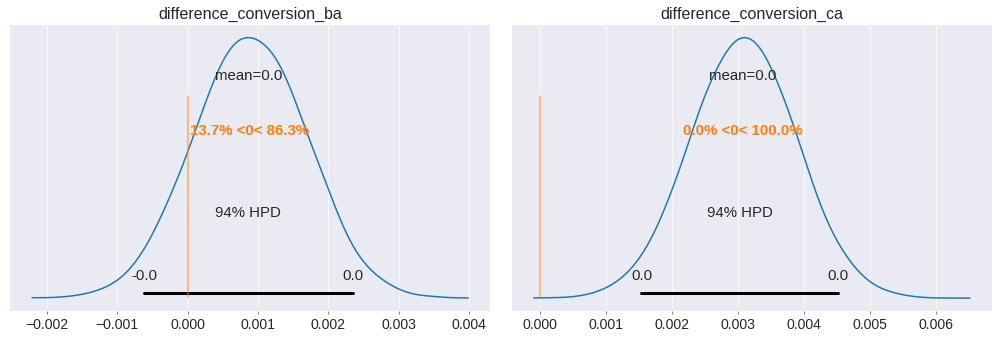

In [0]:
# 이거는 (특가 노출로) 구매 유입인원이 증가한다는 개념에서 당연한결과?
_ = pm.plot_posterior(trace, var_names=['difference_conversion_ba', 'difference_conversion_ca'], 
                      ref_val=0, color='#87ceeb')

## # arpu_revenue

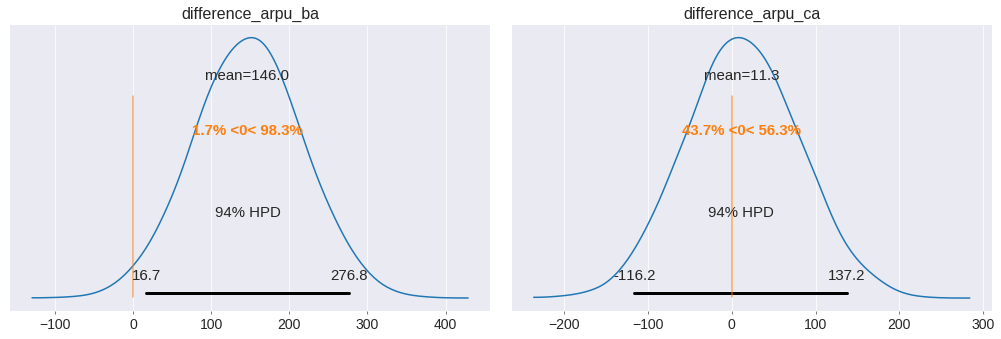

In [0]:
_ = pm.plot_posterior(trace, var_names=['difference_arpu_ba', 'difference_arpu_ca'], 
                      ref_val=0, color='#87ceeb')

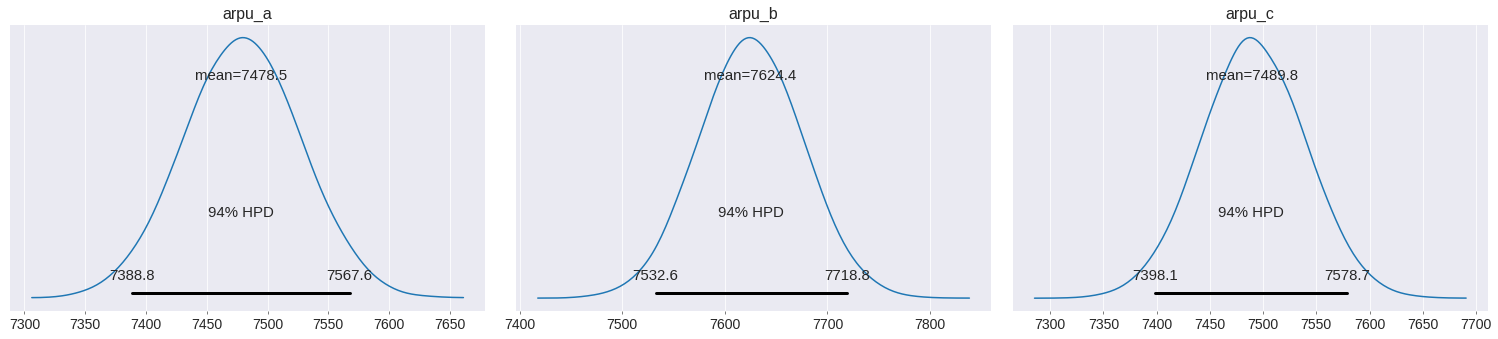

In [0]:
_ = pm.plot_posterior(trace, var_names=['arpu_a', 'arpu_b', 'arpu_c'],
                      color='#87ceeb')

## # arpu_CM

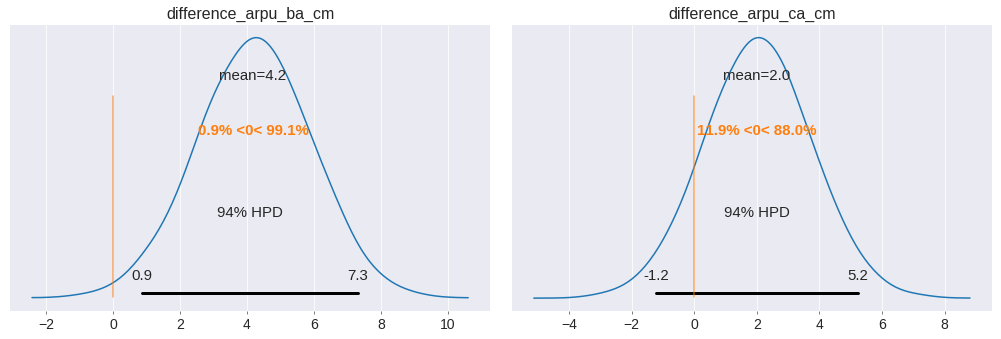

In [0]:
_ = pm.plot_posterior(trace, var_names=['difference_arpu_ba_cm', 'difference_arpu_ca_cm'], 
                      ref_val=0, color='#87ceeb')

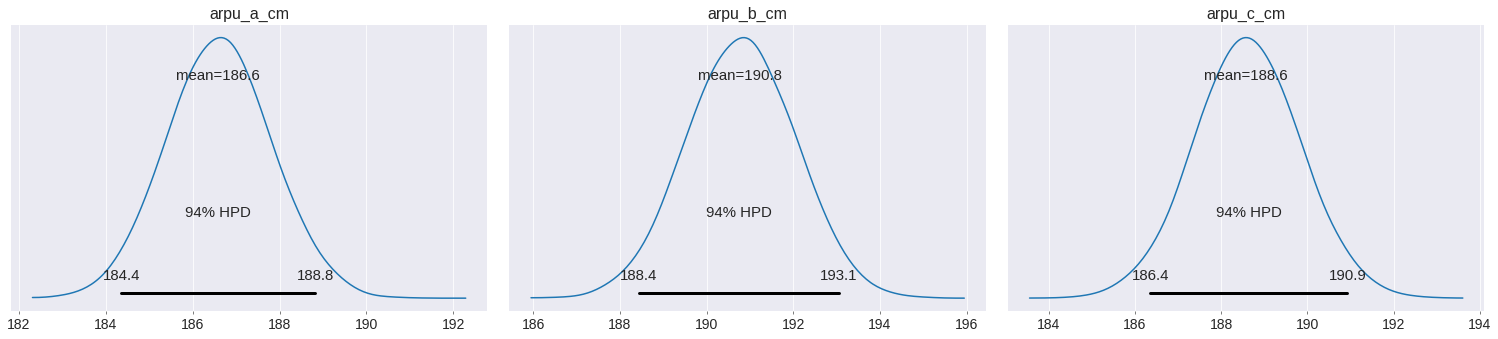

In [0]:
_ = pm.plot_posterior(trace, var_names=['arpu_a_cm', 'arpu_b_cm', 'arpu_c_cm'],
                      color='#87ceeb')



---



## # conversion-rate

In [0]:
fig_title = 'conversionrate_type(with revenue)'
print(fig_title)

conversionrate_type(with revenue)


Text(0.5, 0.98, 'conversionrate_type(with revenue)')

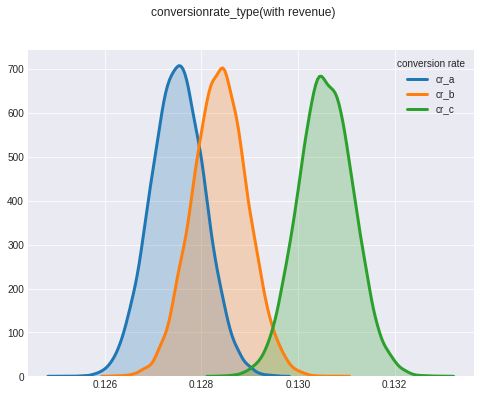

In [0]:
f, ax = plt.subplots(figsize=(8, 6))
sns.distplot(trace['cr_a'], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3}, label='cr_a')
sns.distplot(trace['cr_b'], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3}, label='cr_b')
sns.distplot(trace['cr_c'], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3}, label='cr_c')
plt.legend(title='conversion rate')
f.suptitle(fig_title)
#f.savefig('gdrive/My Drive/data/ab_search/fig_cv_{}.png'.format(fig_title), format='png')

## # arpu_revenue

In [0]:
#name_suffix = '{}_{}.csv'.format(VIEW,DATA)
fig_title = 'arpu_type(with revenue)'
print(fig_title)

arpu_type(with revenue)


Text(0.5, 0.98, 'arpu_type(with revenue)')

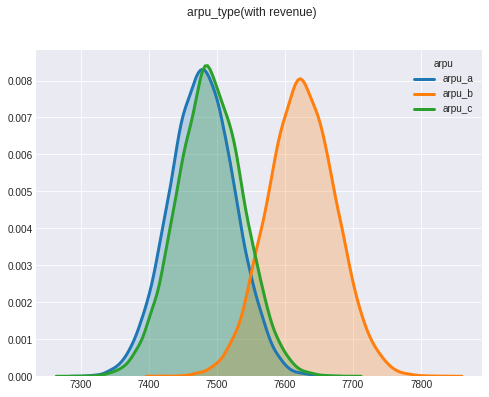

In [0]:
f, ax = plt.subplots(figsize=(8, 6))
sns.distplot(trace['arpu_a'], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3}, label='arpu_a')
sns.distplot(trace['arpu_b'], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3}, label='arpu_b')
sns.distplot(trace['arpu_c'], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3}, label='arpu_c')
plt.legend(title='arpu')
f.suptitle(fig_title)
#f.savefig('gdrive/My Drive/data/ab_search/fig_arpu_{}.png'.format(fig_title), format='png')

## # arpu_CM

In [0]:
fig_title = 'arpu_type(with CM)'
print(fig_title)

arpu_type(with CM)


Text(0.5, 0.98, 'arpu_type(with CM)')

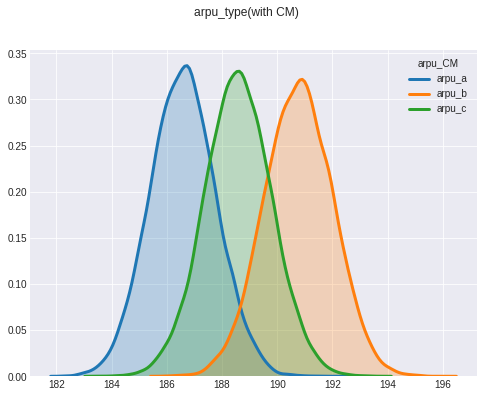

In [0]:
f, ax = plt.subplots(figsize=(8, 6))
sns.distplot(trace['arpu_a_cm'], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3}, label='arpu_a')
sns.distplot(trace['arpu_b_cm'], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3}, label='arpu_b')
sns.distplot(trace['arpu_c_cm'], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3}, label='arpu_c')
plt.legend(title='arpu_CM')
f.suptitle(fig_title)
#f.savefig('gdrive/My Drive/data/ab_search/fig_arpu_{}.png'.format(fig_title), format='png')



---



## # 통계량 살피기

### # conversion 관점

In [0]:
sm_cr = pm.summary(trace, varnames=['difference_conversion_ba','difference_conversion_ca', 'loss_cr_a', 'loss_cr_b', 'loss_cr_c'])

In [0]:
sm_cr

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
difference_conversion_ba,8.722153e-04,0.000793,5.134988e-06,-0.000684,0.002407,23558.347685,0.999952
difference_conversion_ca,3.065332e-03,0.000789,4.967488e-06,0.001522,0.004614,21910.981966,0.999951
loss_cr_a,3.066045e-03,0.000788,4.974312e-06,0.001524,0.004612,21955.188988,0.999951
loss_cr_b,2.193829e-03,0.000798,4.575744e-06,0.000671,0.003806,22978.560864,0.999957
loss_cr_c,7.123350e-07,0.000019,1.416845e-07,0.000000,0.000000,19419.202125,0.999954


### # arpu_revenue 관점

In [0]:
sm_arpu = pm.summary(trace, varnames=['difference_arpu_ba','difference_arpu_ca', 'loss_arpu_a', 'loss_arpu_b', 'loss_arpu_c'])

In [0]:
sm_arpu

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
difference_arpu_ba,145.964293,69.114445,0.436859,9.672981,280.615309,21871.725265,0.999977
difference_arpu_ca,11.278777,67.649625,0.447582,-118.779709,145.177536,21850.037825,0.999961
loss_arpu_a,147.047046,67.517703,0.425754,0.000000,259.439439,21995.352517,0.999968
loss_arpu_b,1.082753,7.296116,0.057718,0.000000,0.000000,15015.070995,1.000058
loss_arpu_c,135.768270,67.937663,0.436857,0.000000,249.100193,22628.991225,0.999951


### # arpu_cm 관점

In [0]:
sm_arpu_cm = pm.summary(trace, varnames=['difference_arpu_ba_cm','difference_arpu_ca_cm', 'loss_arpu_a_cm', 'loss_arpu_b_cm', 'loss_arpu_c_cm'])

In [0]:
sm_arpu_cm

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
difference_arpu_ba_cm,4.179587,1.717752,0.010945,0.630715,7.366233,20468.395970,0.999995
difference_arpu_ca_cm,1.992296,1.706537,0.011134,-1.390755,5.296465,20548.939090,0.999995
loss_arpu_a_cm,4.269445,1.648723,0.010775,0.977701,7.471819,19849.833096,1.000008
loss_arpu_b_cm,0.089858,0.344164,0.002974,0.000000,0.718100,16082.730009,0.999958
loss_arpu_c_cm,2.277149,1.592766,0.010144,0.000000,5.080173,21665.102912,0.999950




---



In [0]:
sm_stat = pm.summary(trace, varnames=['cr_a', 'cr_b', 'cr_c', 'arpu_a', 'arpu_b', 'arpu_c', 'arpu_a_cm', 'arpu_b_cm', 'arpu_c_cm'])

In [0]:
sm_stat

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
cr_a,0.127510,0.000554,0.000004,0.126402,0.128566,23467.830699,1.000005
cr_b,0.128382,0.000566,0.000003,0.127287,0.129508,24348.594948,1.000039
cr_c,0.130575,0.000569,0.000004,0.129478,0.131692,21052.709558,0.999983
arpu_a,7478.471752,47.626009,0.290524,7384.937866,7571.201720,21992.121885,0.999951
arpu_b,7624.436045,49.706274,0.343777,7527.920390,7722.792575,22538.371460,0.999989
arpu_c,7489.750529,48.262003,0.326671,7395.360290,7584.071808,21997.408762,0.999963
arpu_a_cm,186.591199,1.185850,0.008168,184.240998,188.890651,19394.924161,1.000002
arpu_b_cm,190.770786,1.233461,0.008050,188.372916,193.181929,23547.499190,0.999956
arpu_c_cm,188.583495,1.214232,0.007664,186.226494,191.002464,20905.462681,0.999956


In [0]:
np.mean(trace['difference_conversion_ba']>0), np.mean(trace['difference_conversion_ca']>0)

(0.863, 0.99995)

In [0]:
np.mean(trace['difference_arpu_ba']>0), np.mean(trace['difference_arpu_ca']>0)

(0.98295, 0.563)

In [0]:
np.mean(trace['difference_arpu_ba_cm']>0), np.mean(trace['difference_arpu_ca_cm']>0)

(0.99125, 0.8805)

## 결과를 csv로 저장

In [0]:
# pd.DataFrame(
# {'A':[n1, sm2['mean']['cr_a'], sm2['mean']['arpu_a'], sm2['hpd_2.5']['arpu_a'],sm2['hpd_97.5']['arpu_a']],
#  'B':[n2, sm2['mean']['cr_b'], sm2['mean']['arpu_b'], sm2['hpd_2.5']['arpu_b'],sm2['hpd_97.5']['arpu_b']],
#  'diff':[0, sm1['mean']['difference_conversion'], sm1['mean']['difference_arpu'], sm1['hpd_2.5']['difference_arpu'],sm1['hpd_97.5']['difference_arpu']],
# },
# index=['sample size', 'cr', 'arpu', 'hpd2.5', 'hpd97.5']
# ).to_csv('gdrive/My Drive/data/ab_search/stat_'+name_suffix)

In [0]:
# pd.DataFrame(
# {
# 'conversion': [np.mean(trace['difference_conversion']>0), sm1['mean']['uplift_cr'], sm1['mean']['loss_cr']],
# 'arpu': [np.mean(trace['difference_arpu']>0), sm1['mean']['uplift_arpu'], sm1['mean']['loss_arpu']],
# },
# index=['probBgtA','uplift', 'loss']
# ).to_csv('gdrive/My Drive/data/ab_search/decision_'+name_suffix)